In [1]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install tensorflow
!pip install datasets
!pip install -U accelerate
!pip install -U transformers
!pip install matplotlib

## 데이터셋

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('8_Lethal.csv')
df = df[['recommendationid', 'review', 'voted_up']]
df.head()

,recommendationid,review,voted_up
0,166349894,이 게임의 진가는 모드질할때 들어남 바닐라도 충분히 무섭지만 모드로 난이도 대폭 올...,True
1,166343099,리쌀 깜빠니,True
2,166341816,맛있는게임,True
3,166338078,개재밌어요 토끼슈트를 사서 입고 뛰어보세요 뚕 뚕,True
4,166335885,그냥한명버려두고도망치면서나온다음에춤추면갓겜내가먹히면*겜얼굴만봐도웃긴게임,True


### 데이터수 비교


In [4]:
up_score=0
down_score=0
nouns=df['voted_up']
for i in range(len(nouns)):
 if(nouns[i]==True):
  up_score+=1;
 else:
  down_score+=1;

print(down_score)
print(up_score)

241
6186


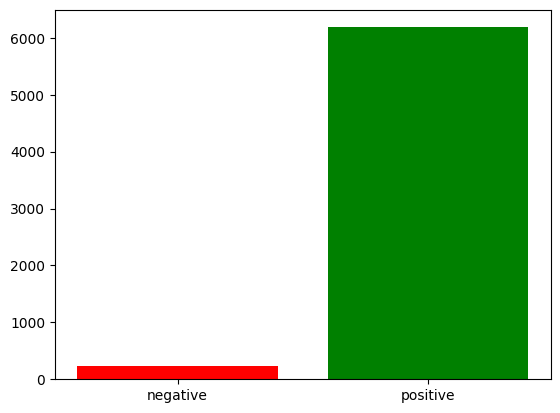

In [5]:
import matplotlib.pyplot as plt
import numpy as np


years = ['negative', 'positive']
values = [down_score, up_score]

plt.bar(years,values,color=['r','g'])



plt.show()

## Negative 정보가 부족해서 데이터 augument 작업

In [6]:
from transformers import BertTokenizer

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [7]:
from tqdm import tqdm

In [8]:
nn_train = df[df['voted_up'] == 0]

In [9]:
#truncate=Truemax_lengthtruncate=True

In [10]:
tokenized = []
for sent in tqdm(nn_train['review']):
#  tokenized.append(bert_tokenizer(sent))
  t = bert_tokenizer.encode_plus(sent,
                                 max_length=254,
                                 padding='max_length',
                                 truncation=True,
                                 return_attention_mask=True)
  tokenized.append(t)

100%|██████████| 241/241 [00:00<00:00, 1417.64it/s]


In [11]:
input_ids = []
attention_masks = []
for sent in tokenized:
  #print(sent['input_ids'])
  input_ids.append(sent['input_ids'])
  attention_masks.append(sent['attention_mask'])





# positive 도 따로 뽑기

In [12]:
pp_train = df[df['voted_up'] == 1]
tokenized_p = []
for sent in tqdm(pp_train['review']):
#  tokenized.append(bert_tokenizer(sent))
  t = bert_tokenizer.encode_plus(sent,
                                  max_length=254,
                                 padding='max_length',
                                 truncation=True,
                                 return_attention_mask=True)
  tokenized_p.append(t)

100%|██████████| 6186/6186 [00:02<00:00, 2238.03it/s]


In [13]:
input_positive = []
attention_masks_positive = []
for sent in tokenized_p:
  #print(sent['input_ids'])
  input_positive.append(sent['input_ids'])
  attention_masks_positive.append(sent['attention_mask'])



## input_ids 복사해서 1. 원본 2. 마스킹 추가 3. swap 추가 > negative 데이터 증가 시키기


In [14]:
import copy
negative_1 = copy.deepcopy(input_ids)
negative_2 =  copy.deepcopy(input_ids)

# input_ids 중간에 마스킹 넣기 [103] 넣어서 데이터 값 증가시키기


In [15]:
import random

In [16]:
for i in range(len(negative_1)):
  final= negative_1[i].index(102)
  rand_num = random.randint(1, final-1)
  negative_1[i][rand_num]=103

In [17]:
import pandas as pd
df = pd.DataFrame(negative_1)
df


,0,1,2,3,4,5,6,7,8,9,...,244,245,246,247,248,249,250,251,252,253
0,101,100,1455,30017,30021,1463,30010,30022,29997,30019,...,0,0,0,0,0,0,0,0,0,0
1,101,1459,30014,29997,30008,29999,30015,103,30013,102,...,0,0,0,0,0,0,0,0,0,0
2,101,103,102,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,101,1455,30009,29999,30019,30023,30000,30011,30023,1469,...,0,0,0,0,0,0,0,0,0,0
4,101,1455,30019,30023,29995,30019,30021,29991,30010,30022,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,101,1465,30006,30023,29991,30011,1463,30019,30021,30004,...,30014,30021,1457,30006,1463,30010,30022,29999,30008,102
237,101,100,1463,30006,30021,29996,30011,29991,30011,1469,...,0,0,0,0,0,0,0,0,0,0
238,101,100,1008,1008,1456,30017,30021,29995,30011,29994,...,0,0,0,0,0,0,0,0,0,0
239,101,1463,30019,29991,30009,100,1463,103,30024,29993,...,0,0,0,0,0,0,0,0,0,0


In [18]:
df.to_csv('103.csv', index=False)

## mask 추가됨
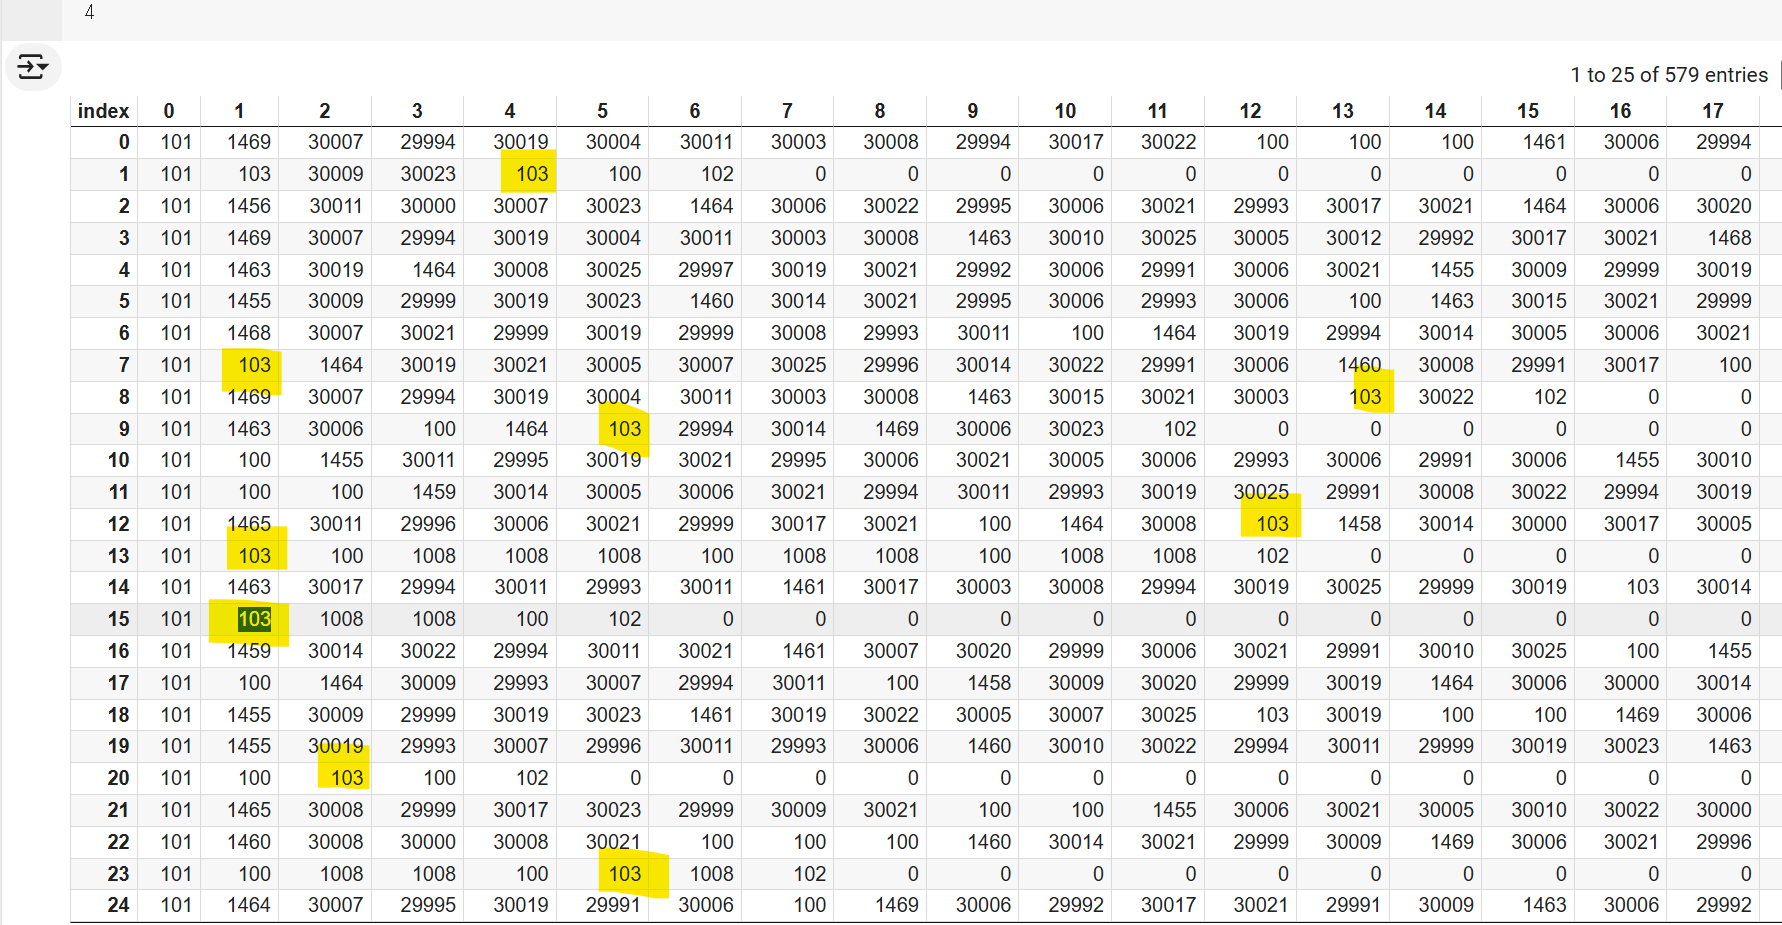

In [19]:
import pandas as pd
neg_2_df = pd.DataFrame(negative_2)
neg_2_df

,0,1,2,3,4,5,6,7,8,9,...,244,245,246,247,248,249,250,251,252,253
0,101,100,1455,30017,30021,1463,30010,30022,29997,30019,...,0,0,0,0,0,0,0,0,0,0
1,101,1459,30014,29997,30008,29999,30015,29999,30013,102,...,0,0,0,0,0,0,0,0,0,0
2,101,100,102,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,101,1455,30009,29999,30019,30023,30000,30011,30023,1469,...,0,0,0,0,0,0,0,0,0,0
4,101,1455,30019,30023,29995,30019,30021,29991,30010,30022,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,101,1465,30006,30023,29991,30011,1463,30019,30021,30004,...,30014,30021,1457,30006,1463,30010,30022,29999,30008,102
237,101,100,1463,30006,30021,29996,30011,29991,30011,1469,...,0,0,0,0,0,0,0,0,0,0
238,101,100,1008,1008,1456,30017,30021,29995,30011,29994,...,0,0,0,0,0,0,0,0,0,0
239,101,1463,30019,29991,30009,100,1463,30006,30024,29993,...,0,0,0,0,0,0,0,0,0,0


In [20]:
for i in range(len(negative_2)):

  final= negative_2[i].index(102)
  if(final<=3):
    continue
  rand_num_1 = random.randint(1, final-1)
  rand_num_2 = random.randint(1, final-1)
  print(i)
  while(rand_num_1==rand_num_2):
   rand_num_1 = random.randint(1, final-1)
   rand_num_2 = random.randint(1, final-1)

  temp = negative_2[i][rand_num_1]
  negative_2[i][rand_num_1] = negative_2[i][rand_num_2]
  negative_2[i][rand_num_2] = temp



0
1
3
4
5
6
7
8
9
10
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
43
44
45
46
47
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
72
73
74
75
76
77
78
79
81
82
83
84
85
86
87
89
90
91
92
93
94
95
96
98
99
100
101
102
103
104
105
106
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
210
211
212
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240


In [21]:
import pandas as pd
df_1 = pd.DataFrame(negative_2)
df_1

,0,1,2,3,4,5,6,7,8,9,...,244,245,246,247,248,249,250,251,252,253
0,101,100,1455,30017,30021,1463,30010,30022,29997,30019,...,0,0,0,0,0,0,0,0,0,0
1,101,1459,30014,29997,30008,29999,30013,29999,30015,102,...,0,0,0,0,0,0,0,0,0,0
2,101,100,102,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,101,1455,30009,29999,30019,30023,30000,30011,30023,1469,...,0,0,0,0,0,0,0,0,0,0
4,101,1455,30009,30023,29995,30019,30021,29991,30010,30022,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,101,1465,30006,30023,29991,30011,1463,30019,30021,30004,...,30014,30021,1457,30006,1463,30010,30022,29999,30008,102
237,101,100,1463,30006,30021,29996,30011,29991,30011,1469,...,0,0,0,0,0,0,0,0,0,0
238,101,100,1008,1008,1456,30017,30021,29995,30011,29994,...,0,0,0,0,0,0,0,0,0,0
239,101,1463,30019,29991,30009,100,1463,30006,30024,29993,...,0,0,0,0,0,0,0,0,0,0


In [22]:
df_1.to_csv('kkk.csv', index=False)

###input_ids 에 합치지 / mask id 합치기


In [23]:
print(len(negative_1))
print(len(negative_2))
print(len(input_ids))

241
241
241


In [24]:
combined_ids = negative_1 + negative_2 + input_ids
#attention_masks = []

combined_mask = attention_masks + attention_masks + attention_masks

In [25]:
import pandas as pd
combine_df = pd.DataFrame(combined_ids)
combine_df

,0,1,2,3,4,5,6,7,8,9,...,244,245,246,247,248,249,250,251,252,253
0,101,100,1455,30017,30021,1463,30010,30022,29997,30019,...,0,0,0,0,0,0,0,0,0,0
1,101,1459,30014,29997,30008,29999,30015,103,30013,102,...,0,0,0,0,0,0,0,0,0,0
2,101,103,102,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,101,1455,30009,29999,30019,30023,30000,30011,30023,1469,...,0,0,0,0,0,0,0,0,0,0
4,101,1455,30019,30023,29995,30019,30021,29991,30010,30022,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718,101,1465,30006,30023,29991,30011,1463,30019,30021,30004,...,30014,30021,1457,30006,1463,30010,30022,29999,30008,102
719,101,100,1463,30006,30021,29996,30011,29991,30011,1469,...,0,0,0,0,0,0,0,0,0,0
720,101,100,1008,1008,1456,30017,30021,29995,30011,29994,...,0,0,0,0,0,0,0,0,0,0
721,101,1463,30019,29991,30009,100,1463,30006,30024,29993,...,0,0,0,0,0,0,0,0,0,0


## positive negative 데이터수 확인


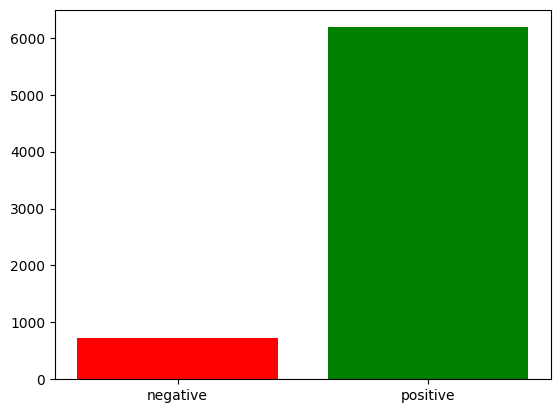

In [26]:
import matplotlib.pyplot as plt
import numpy as np


years = ['negative', 'positive']
values = [len(combined_ids), len(input_positive)]

plt.bar(years,values,color=['r','g'])



plt.show()

#positive negative 를 split 하기

In [27]:
len(pp_train)

6186

In [28]:
origin_train=copy.deepcopy(nn_train)

In [29]:
nn_train = pd.concat([nn_train, nn_train], axis=0)

In [30]:
len(nn_train)

482

In [31]:
len(origin_train)

241

In [32]:
len(pp_train)

6186

In [33]:
nn_train = pd.concat([origin_train, nn_train], axis=0)

In [34]:
len(nn_train)

723

postive+ negative 해서 나누기

### input_ids 합치기

In [35]:
total_id= input_positive+ combined_ids

In [36]:
import pandas as pd
total_df = pd.DataFrame(total_id)
total_df

,0,1,2,3,4,5,6,7,8,9,...,244,245,246,247,248,249,250,251,252,253
0,101,1463,30019,1455,30009,29999,30019,30023,29999,30018,...,0,0,0,0,0,0,0,0,0,0
1,101,1458,30019,29998,30006,30022,100,102,0,0,...,0,0,0,0,0,0,0,0,0,0
2,101,100,102,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,101,100,100,1461,30006,29997,30008,1463,30019,30024,...,0,0,0,0,0,0,0,0,0,0
4,101,100,1008,100,102,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6904,101,1465,30006,30023,29991,30011,1463,30019,30021,30004,...,30014,30021,1457,30006,1463,30010,30022,29999,30008,102
6905,101,100,1463,30006,30021,29996,30011,29991,30011,1469,...,0,0,0,0,0,0,0,0,0,0
6906,101,100,1008,1008,1456,30017,30021,29995,30011,29994,...,0,0,0,0,0,0,0,0,0,0
6907,101,1463,30019,29991,30009,100,1463,30006,30024,29993,...,0,0,0,0,0,0,0,0,0,0


### mask_id 합치기

In [37]:
total_mask= attention_masks_positive+combined_mask

### df['review'] 합치기

In [38]:
total_df = pd.concat([pp_train, nn_train], axis=0)

In [39]:
print(len(total_id))
print(len(total_mask))
print(len(total_df))

6909
6909
6909


In [40]:
total_df

,recommendationid,review,voted_up
0,166349894,이 게임의 진가는 모드질할때 들어남 바닐라도 충분히 무섭지만 모드로 난이도 대폭 올...,True
1,166343099,리쌀 깜빠니,True
2,166341816,맛있는게임,True
3,166338078,개재밌어요 토끼슈트를 사서 입고 뛰어보세요 뚕 뚕,True
4,166335885,그냥한명버려두고도망치면서나온다음에춤추면갓겜내가먹히면*겜얼굴만봐도웃긴게임,True
...,...,...,...
6268,152870629,참고 인플 처음에는 재밌음 초반 공포분위기에 함정 피하고 몹 만나면서 탐험하는 맛이...,False
6270,152870333,공략 안보고 하는게 좋다고 들어서 공략 안보고 인으로 했는데 걍 어렵고 뒤지다가 환...,False
6405,150481051,한국인찾기힘듬비매너많음결론친구랑같이하기는매우좋은게임이지만나처럼개찐따**는모르는사람이...,False
6413,150341705,이게 왜 압도적으로 재밌는 게임인 것인지 의문 아마 친구들끼리 하는 게임이다 보니까...,False


In [41]:
train_inputs, validation_inputs, train_labels, validation_labels = \
train_test_split(total_id, total_df['voted_up'].values, random_state=42, test_size=0.1)

In [42]:
train_masks, validation_masks, _, _ = train_test_split(total_mask, total_id, random_state=42,test_size=0.1)


In [43]:
import torch


In [44]:
train_labels

array([ True,  True,  True, ...,  True,  True,  True])

In [45]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)


In [46]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


In [47]:
print('set batch and data loader')
BATCH_SIZE = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)


set batch and data loader


In [48]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
from transformers import BertForSequenceClassification, AdamW, BertConfig


In [50]:
from transformers import get_linear_schedule_with_warmup


In [51]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 4

# 총 훈련 스텝
total_steps = len(train_dataloader) * epochs

# lr 조금씩 감소시키는 스케줄러
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

##학습
# accuracy 와 시간 표시함수 정의
# 정확도 계산 함수
print('train start')
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):
    # 반올림
    elapsed_rounded = int(round((elapsed)))
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))


train start


c:\Users\admin\anaconda3\envs\text\lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [52]:
import time

In [62]:
import random
import numpy as np
import torch
import time
from torch.utils.data import DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup

# 사용 가능하면 device를 GPU로 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Seed 설정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 데이터셋 및 데이터 로더 정의
train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=4, shuffle=False)

# 모델을 device로 이동
model.to(device)

# 옵티마이저와 스케줄러 설정
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# 정확도 계산 함수
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 에폭만큼 반복
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')

    t0 = time.time()
    total_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            elapsed = time.time() - t0
            print(f'  Batch {step}  of  {len(train_dataloader)}.    Elapsed: {elapsed:.2f}.')

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # 레이블과 마스크를 long 타입으로 변환
        b_labels = b_labels.long()
        b_input_mask = b_input_mask.long()

        print(f"Batch {step} - Input IDs shape: {b_input_ids.shape}, Attention Mask shape: {b_input_mask.shape}, Labels shape: {b_labels.shape}")
        print(f"Data types - Input IDs: {b_input_ids.dtype}, Attention Mask: {b_input_mask.dtype}, Labels: {b_labels.dtype}")

        model.zero_grad()

        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

        logits = outputs[0]

        # 손실 함수와 로짓, 레이블의 크기 맞추기
        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits, b_labels)

        total_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)

    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epoch took: {time.time() - t0:.2f}")

    # ========================================
    #               Validation
    # ========================================

    print("Running Validation...")

    t0 = time.time()
    model.eval()

    eval_accuracy = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # 레이블과 마스크를 long 타입으로 변환
        b_labels = b_labels.long()
        b_input_mask = b_input_mask.long()
        print(f"Validation - Input IDs shape: {b_input_ids.shape}, Attention Mask shape: {b_input_mask.shape}, Labels shape: {b_labels.shape}")
        print(f"Data types - Input IDs: {b_input_ids.dtype}, Attention Mask: {b_input_mask.dtype}, Labels: {b_labels.dtype}")


        with torch.no_grad():
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        logits = outputs[0]

        # 로짓과 레이블의 크기 맞추기
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print(f"  Accuracy: {eval_accuracy / nb_eval_steps:.2f}")
    print(f"  Validation took: {time.time() - t0:.2f}")

print("Training complete!")


======== Epoch 1 / 4 ========
Training...
Batch 0 - Input IDs shape: torch.Size([4, 254]), Attention Mask shape: torch.Size([4, 254]), Labels shape: torch.Size([4])
Data types - Input IDs: torch.int64, Attention Mask: torch.int64, Labels: torch.int64
Batch 1 - Input IDs shape: torch.Size([4, 254]), Attention Mask shape: torch.Size([4, 254]), Labels shape: torch.Size([4])
Data types - Input IDs: torch.int64, Attention Mask: torch.int64, Labels: torch.int64
Batch 2 - Input IDs shape: torch.Size([4, 254]), Attention Mask shape: torch.Size([4, 254]), Labels shape: torch.Size([4])
Data types - Input IDs: torch.int64, Attention Mask: torch.int64, Labels: torch.int64
Batch 3 - Input IDs shape: torch.Size([4, 254]), Attention Mask shape: torch.Size([4, 254]), Labels shape: torch.Size([4])
Data types - Input IDs: torch.int64, Attention Mask: torch.int64, Labels: torch.int64
Batch 4 - Input IDs shape: torch.Size([4, 254]), Attention Mask shape: torch.Size([4, 254]), Labels shape: torch.Size([4])

KeyboardInterrupt: 

In [ ]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t for t in batch)

        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        # 로스 구함
        loss, logits = outputs[:2]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t for t in batch)

        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # 그래디언트 계산 안함
        with torch.no_grad():
            # Forward 수행
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)
            logits = outputs[0]

            # logits와 label 크기 맞추기
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # 출력 로짓과 라벨을 비교하여 정확도 계산
            tmp_eval_accuracy = flat_accuracy(logits, label_ids)
            eval_accuracy += tmp_eval_accuracy
            nb_eval_steps += 1

        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # 출력 로직과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")
print("")


======== Epoch 1 / 4 ========
Training...


ValueError: Target size (torch.Size([32])) must be the same as input size (torch.Size([32, 2]))

## 새로운 링크 따라하기


In [ ]:
x_train, x_test, y_train, y_test, mask_train, mask_test = train_test_split(total_id, total_df['review'], total_mask, test_size=0.2, random_state=42)
print("x_train: {}개,\ty_train: {}개".format(len(x_train), len(y_train)))
print("x_test: {}개,\ty_test: {}개".format(len(x_test), len(y_test)))
print("mask_train: {}개,\tmask_test: {}개".format(len(mask_train), len(mask_test)))

x_train: 4322개,	y_train: 4322개
x_test: 1081개,	y_test: 1081개
mask_train: 4322개,	mask_test: 1081개


In [ ]:
x_train, x_valid, y_train, y_valid, mask_train, mask_valid = train_test_split(x_train, y_train, mask_train, test_size=0.2, random_state=42)
print("x_train: {}개,\ty_train: {}개".format(len(x_train), len(y_train)))
print("x_valid: {}개,\ty_valid: {}개".format(len(x_valid), len(y_valid)))
print("mask_train: {}개,\tmask_valid: {}개".format(len(mask_train), len(mask_valid)))

x_train: 3457개,	y_train: 3457개
x_valid: 865개,	y_valid: 865개
mask_train: 3457개,	mask_valid: 865개


In [ ]:
len(total_id[10])

256

In [ ]:
x_train[10]

[101,
 1463,
 30019,
 29991,
 30009,
 30023,
 1468,
 30017,
 30022,
 29994,
 30009,
 29999,
 30019,
 1464,
 30008,
 30021,
 1463,
 30006,
 29996,
 30006,
 29993,
 30006,
 1466,
 30009,
 29993,
 30006,
 29996,
 30017,
 29994,
 30006,
 1463,
 30019,
 29991,
 30009,
 30023,
 1468,
 30017,
 30022,
 29994,
 30009,
 29999,
 30019,
 1469,
 30014,
 1463,
 30006,
 29996,
 30006,
 29993,
 30006,
 1466,
 30009,
 29993,
 30006,
 29996,
 30017,
 29994,
 30006,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0

##Train 하기

In [ ]:
import tensorflow as tf

In [ ]:
pip install transformers tensorflow

In [ ]:
from transformers import TFBertForSequenceClassification
bert_model1 = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TFBertForSequenceClassification, BertTokenizer
import tensorflow as tf

In [ ]:
bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
bert_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

ValueError: Could not interpret optimizer identifier: <keras.src.optimizers.adam.Adam object at 0x7a062d5843d0>

# x_train 데이터 불균형 확인

In [ ]:
df_train = pd.DataFrame(x_train)
df_train

,0,1,2,3,4,5,6,7,8,9,...,244,245,246,247,248,249,250,251,252,253
0,101,100,1008,100,1008,102,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,101,100,100,100,1455,30008,1455,30011,30001,30019,...,0,0,0,0,0,0,0,0,0,0
2,101,100,100,1463,30007,30021,1460,30014,30022,29998,...,0,0,0,0,0,0,0,0,0,0
3,101,1469,30007,29994,30019,30004,30011,30003,30008,1461,...,0,0,0,0,0,0,0,0,0,0
4,101,1455,30014,30025,29991,30017,30023,1469,30006,29995,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3452,101,1461,30019,29991,30006,30021,29993,30011,30025,29999,...,0,0,0,0,0,0,0,0,0,0
3453,101,100,100,102,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3454,101,1469,30007,29994,30019,30004,30011,30003,30008,30000,...,0,0,0,0,0,0,0,0,0,0
3455,101,100,102,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
dfmask_train = pd.DataFrame(mask_train)
dfmask_train

,0,1,2,3,4,5,6,7,8,9,...,244,245,246,247,248,249,250,251,252,253
0,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3452,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3453,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3454,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3455,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_train.to_csv('train_.csv', index=False)

In [ ]:
training_x = np.array(x_train)
training_mask = np.array(mask_train)

In [ ]:
vaild_x = np.array(x_valid)
vaild_mask = np.array(mask_valid)
vaild_y= np.array(y_valid)


In [ ]:
train_y= np.array(y_train)

### Faild to convert a Numpu array to Tensor

In [ ]:
len(training_x)

3457

In [ ]:
len(training_mask)

3457

In [ ]:
len(train_y)

3457

In [ ]:
training_x=training_x.astype(np.float32)
training_mask=training_mask.astype(np.float32)


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

In [ ]:
bert_model1 .compile(optimizer = optimizer, loss='binary_crossentropy', metrics=['accuracy'])

ValueError: Could not interpret optimizer identifier: <keras.src.optimizers.adam.Adam object at 0x7a06295017b0>

In [ ]:
x_train, x_valid, y_train, y_valid, mask_train, mask_valid = train_test_split(x_train, y_train, mask_train, test_size=0.2, random_state=42)
print("x_train: {}개,\ty_train: {}개".format(len(x_train), len(y_train)))
print("x_valid: {}개,\ty_valid: {}개".format(len(x_valid), len(y_valid)))
print("mask_train: {}개,\tmask_valid: {}개".format(len(mask_train), len(mask_valid)))

x_train: 2716개,	y_train: 2716개
x_valid: 680개,	y_valid: 680개
mask_train: 2716개,	mask_valid: 680개


In [ ]:
x_train[0]

array([  101,   100,  1455, 30017, 30021, 29993, 30009,  1455, 30017,
       29994, 30007, 30004, 30019, 30020,   100,   100,  1469, 30012,
       29995, 30010, 30021,   100,  1459, 30008, 30023, 30001, 30014,
       29992, 30017,   102])

In [ ]:
mask_train[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [ ]:
from transformers import TFBertForSequenceClassification

In [ ]:
bert_model2 = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import random
rd_train = nn_train.copy()


for i in range(len(rd_train)):
  rand_num = random.randint(1, len(rd_train.values[i]))
  if(int(rd_train.iloc[i, rand_num]) != 0 & int(rd_train.iloc[i, rand_num]) != 102):
    rd_train.iloc[i, rand_num] = 103
  else:
    while(int(rd_train.iloc[i, rand_num]) == 0 & int(rd_train.iloc[i, rand_num]) == 102):
      rand_num = random.randint(1, len(rd_train.values[i]))
      if(int(rd_train.iloc[i, rand_num]) != 0 & int(rd_train.iloc[i, rand_num]) != 102):
        rd_train.iloc[i, rand_num] = 103
    rand_num = random.randint(1, len(rd_train.values[i]))

IndexError: index 3 is out of bounds for axis 0 with size 3